In [71]:
!pip install community
import pandas as pd
import os
import matplotlib.pyplot as plt
import seaborn as sns
from preprocessing import load_and_combine_csv_files
import requests
from IPython.display import Image, display
import requests
import math
import networkx as nx
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from collections import defaultdict
import community
import seaborn as sns

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
  Preparing metadata (setup.py) ... done
  Created wheel for community: filename=community-1.0.0b1-py3-none-any.whl size=2137 sha256=3d8d766a68c72f08bbdc65105a80beb55b83aa0f843eeff0c2b3bfccc3c7cf06
  Stored in directory: /sise/home/yuvalgor/.cache/pip/wheels/e5/32/7b/aebaa96975f39189b78d7b123cf90e5fd2f0418953833b3043
Successfully built community


## collect data

In [16]:
# Parameters for loading data
directory = "/sise/eliorsu-group/yuvalgor/courses/Data-mining-in-Big-Data/datasets/"
base_filename = "goodwill_items_job_"
num_files = 30

# Load and combine the CSV files
combined_df = load_and_combine_csv_files(directory, base_filename, num_files)
combined_df

itemId                                              title  \
0        217000000  GREATHE Women's multi color floral print shirt...   
1        217000001  [NWT] Sonnet Shores Women's Size 14 black meta...   
2        217000002  Women's Gray/Pink Zip Up Track ADIDAS Jacket -...   
3        217000003  Xersion Size XSmall Blue And Coral Active Tank...   
4        217000004  Women's Beige Zip Up Calvin Klein Jacket - Siz...   
...            ...                                                ...   
1237947  218587858  6 Nintendo Wii Games: NCIS, Wii Fit Plus, LEGO...   
1237948  218587880  Lucky Brand Los Angeles Brown 5-Pocket Design ...   
1237949  218587882                                Assorted Brooch Lot   
1237950  218587915  Lot of 3 Gold Tone 925 Silver Chain Necklaces ...   
1237951  218587923             Kate Spade Nude Heels - Women's Size 6   

                   mainCategory       subCategory  categoryId  \
0                      Clothing  Women's Clothing        1355   
1                      Clothing  Women's Clothing         359   
2                      Clothing  Women's Clothing         348   
3                      Clothing  Women's Clothing         156   
4                      Clothing  Women's Clothing         154   
...                         ...               ...         ...   
1237947  Gaming Systems & Games      Nintendo Wii         300   
1237948                Clothing    Men's Clothing         320   
1237949     Jewelry & Gemstones     Brooches/Pins         100   
1237950     Jewelry & Gemstones         Necklaces          86   
1237951                Clothing  Women's Clothing         162   

                                              categoryName  currentPrice  \
0        10|Clothing|27|Women's Clothing|156|Shirts/Blo...          9.99   
1             10|Clothing|27|Women's Clothing|359|Swimwear         19.99   
2        10|Clothing|27|Women's Clothing|348|Athletic A...         19.99   
3        10|Clothing|27|Women's Clothing|156|Shirts/Blo...         19.99   
4            10|Clothing|27|Women's Clothing|154|Outerwear         19.99   
...                                                    ...           ...   
1237947         33|Gaming Systems & Games|300|Nintendo Wii          7.99   
1237948            10|Clothing|28|Men's Clothing|320|Jeans          9.99   
1237949            6|Jewelry & Gemstones|100|Brooches/Pins          9.99   
1237950                 6|Jewelry & Gemstones|86|Necklaces          9.99   
1237951  10|Clothing|27|Women's Clothing|162|Shoes Women's          9.99   

         numberOfBids  remainingTime  \
0                   0  Auction Ended   
1                   0  Auction Ended   
2                   0  Auction Ended   
3                   0  Auction Ended   
4                   0  Auction Ended   
...               ...            ...   
1237947             0         1d 8h    
1237948             0         3d 9h    
1237949             0        5d 10h    
1237950             0         5d 8h    
1237951             0         5d 8h    

                                               description  \
0        Measured Laying Flat In Inches Description: GR...   
1        Measured Laying Flat In Inches Description: Th...   
2        Category: Women's Color/Pattern: Gray/Pink Zip...   
3        Measured Laying Flat In Inches Description: Th...   
4        Category: Women's Color/Pattern: Beige Zip Up ...   
...                                                    ...   
1237947  6 Nintendo Wii Games: NCIS, Wii Fit Plus, LEGO...   
1237948  Condition: This item is in good condition with...   
1237949  Assorted Brooch Lot Material & Karats (if appl...   
1237950  Sterling Silver Jewelry Set Material & Karats ...   
1237951  Item: Kate Spade Heels Size: Women's 6 Conditi...   

                                                 imageUrls   pickupCity  \
0        https://shopgoodwillimages.azureedge.net/produ...  Falls Creek   
1        https://shopgoodwillimages.azureedge.net/produ...  Falls

## pre processing

In [17]:

missing_values = combined_df.isnull().sum()
print("Missing values in each column:")
print(missing_values)

Missing values in each column:
itemId                        0
title                        27
mainCategory                 54
subCategory              164773
categoryId                    0
categoryName                 27
currentPrice                  0
numberOfBids                  0
remainingTime             18718
description                6687
imageUrls                   243
pickupCity                30990
pickupState                  74
sellerCompanyName            74
sellerLandingPageName        80
keyWords                     61
dtype: int64


In [18]:
# Filter out invalid prices and missing image URLs
def clean_data(df):
    """
    Clean data by processing text columns and filtering invalid entries.
    """
    df = df.copy()

    # Clean text columns
    df['title'] = df['title'].apply(lambda x: str(x).lower().strip() if pd.notna(x) else '')
    df['description'] = df['description'].apply(lambda x: str(x).lower().strip() if pd.notna(x) else '')

    # Filter out invalid prices and missing images
    df = df[df['currentPrice'] > 0]
    df = df[df['imageUrls'].notna()]
    df = df[df['imageUrls'] != '']

    # Filter out warning phrases
    warning_phrases = ['do not bid', 'dont bid', "don't bid", 'not for sale', 'do not buy',
                      'dont buy', "don't buy", '***', 'testing', 'test listing']

    def has_warning(title):
        title_lower = str(title).lower()
        return not any(phrase in title_lower for phrase in warning_phrases)

    # Apply filter
    df = df[df['title'].apply(has_warning)]

    return df

combined_df = clean_data(combined_df)

## Data analysis


Detailed Price Range Distribution:
            Range   Count  Percentage
0         $0 - $1      83    0.006707
1         $1 - $5   45066    3.641897
2        $5 - $10  509085   41.140442
3       $10 - $20  457641   36.983123
4       $20 - $30  105726    8.543985
5       $30 - $40   43465    3.512516
6       $40 - $50   22685    1.833232
7       $50 - $75   21252    1.717428
8      $75 - $100   10675    0.862674
9     $100 - $250   15158    1.224956
10    $250 - $500    3847    0.310886
11  $500 - $1,000    1524    0.123158
12        $1,000+    1225    0.098995


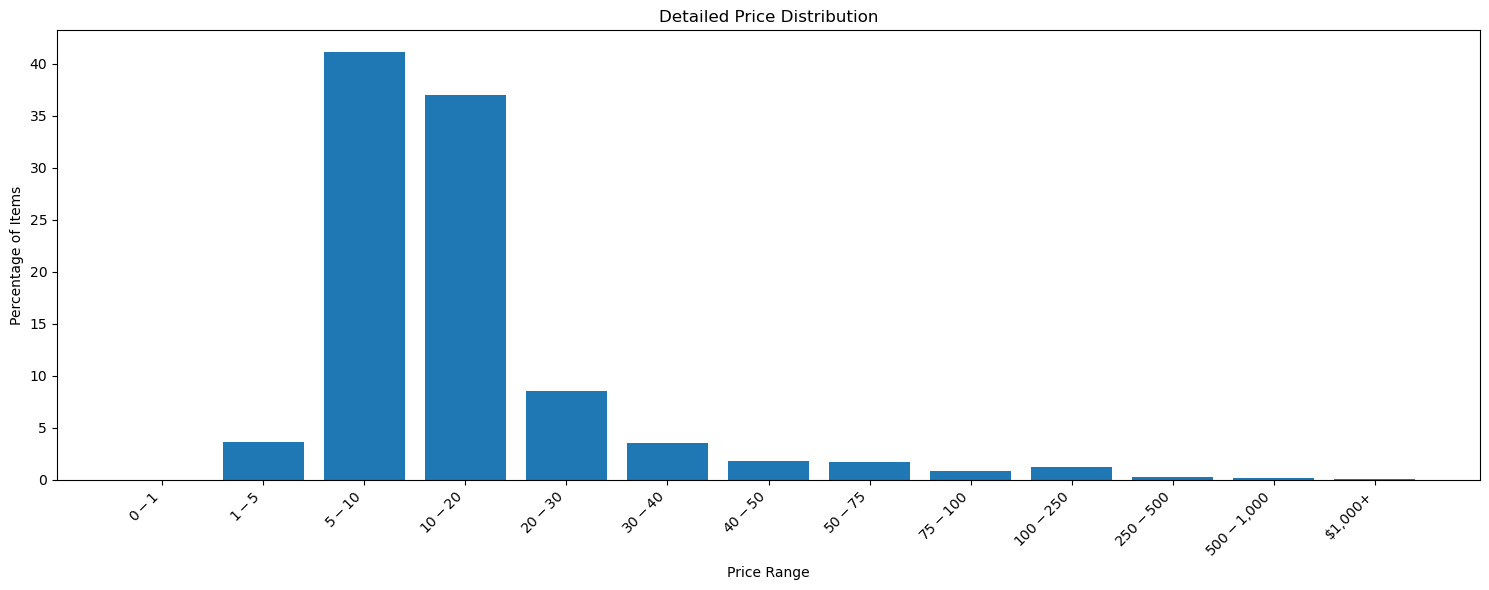

In [19]:
# More detailed price ranges analysis with focus on lower prices
price_ranges = [
    (0, 1),
    (1, 5),
    (5, 10),
    (10, 20),
    (20, 30),
    (30, 40),
    (40, 50),
    (50, 75),
    (75, 100),
    (100, 250),
    (250, 500),
    (500, 1000),
    (1000, float('inf'))
]

range_counts = []
for start, end in price_ranges:
    count = len(combined_df[(combined_df['currentPrice'] > start) & (combined_df['currentPrice'] <= end)])
    range_counts.append({
        'Range': f'${start:,} - ${end:,}' if end != float('inf') else f'${start:,}+',
        'Count': count,
        'Percentage': (count/len(combined_df))*100
    })

range_df = pd.DataFrame(range_counts)
print("\nDetailed Price Range Distribution:")
print(range_df)

# Visualize the distribution
plt.figure(figsize=(15, 6))
plt.bar(range_df['Range'], range_df['Percentage'])
plt.title('Detailed Price Distribution')
plt.xlabel('Price Range')
plt.ylabel('Percentage of Items')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

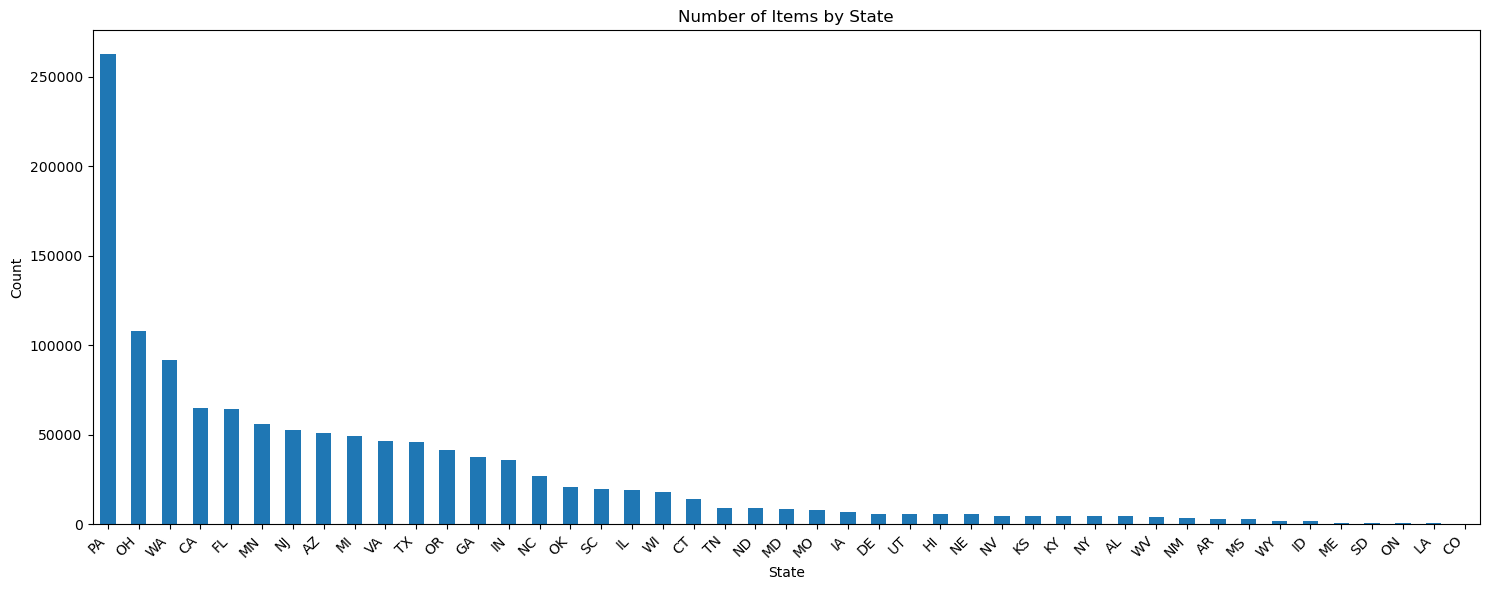

In [20]:
# Cell 1: First let's see the distribution of items by state
state_counts = combined_df['pickupState'].value_counts()
plt.figure(figsize=(15, 6))
state_counts.plot(kind='bar')
plt.title('Number of Items by State')
plt.xlabel('State')
plt.ylabel('Count')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

In [21]:
# Filter out invalid prices and missing image URLs
combined_df = combined_df[
    (combined_df['currentPrice'] > 0) & 
    (combined_df['imageUrls'].notna()) & 
    (combined_df['imageUrls'] != '')
]

print("\nAfter filtering:")
print("Total rows:", len(combined_df))



Before filtering:
Total rows: 1237432

After filtering:
Total rows: 1237432


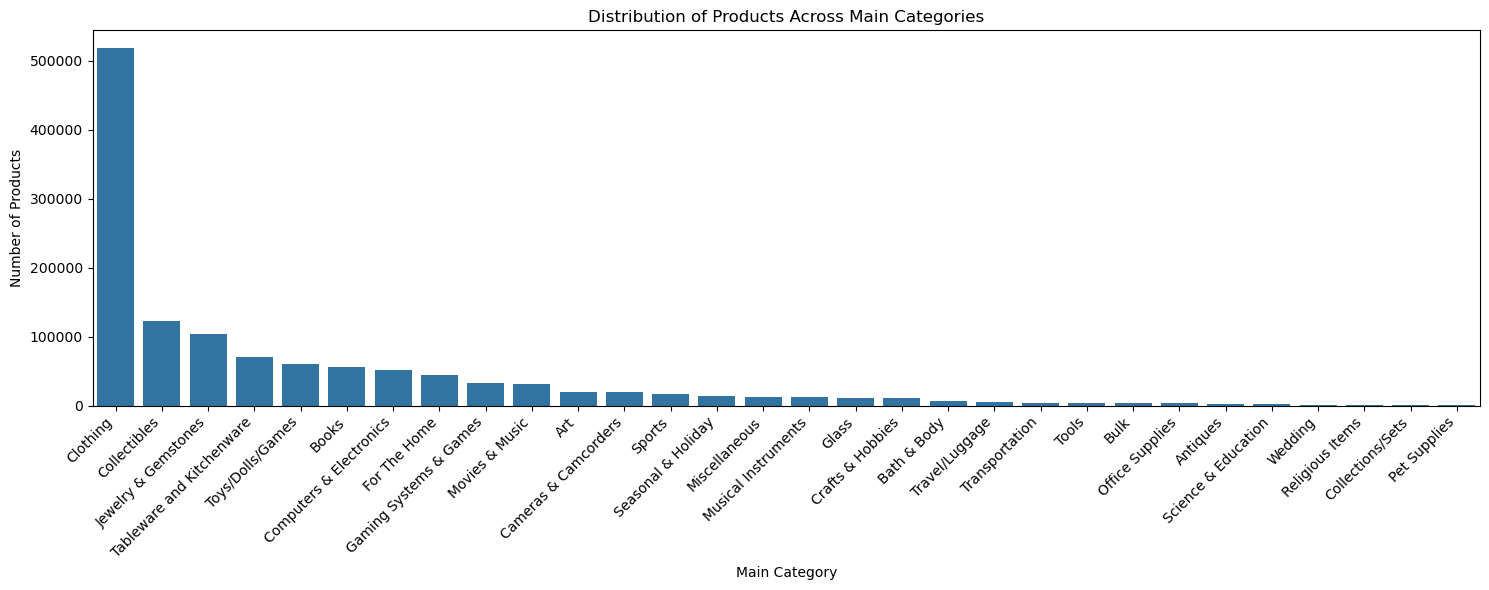


Category Distribution:
mainCategory
Clothing                     518211
Collectibles                 123110
Jewelry & Gemstones          103736
Tableware and Kitchenware     70012
Toys/Dolls/Games              59597
Books                         55718
Computers & Electronics       51509
For The Home                  43573
Gaming Systems & Games        32974
Movies & Music                30951
Art                           19930
Cameras & Camcorders          19737
Sports                        16495
Seasonal & Holiday            13870
Miscellaneous                 12514
Musical Instruments           12029
Glass                         11314
Crafts & Hobbies              10168
Bath & Body                    6403
Travel/Luggage                 4366
Transportation                 3765
Tools                          3426
Bulk                           3312
Office Supplies                3196
Antiques                       1837
Science & Education            1702
Wedding                    

In [23]:
# Category Distribution Analysis
plt.figure(figsize=(15, 6))
category_counts = combined_df['mainCategory'].value_counts()
sns.barplot(x=category_counts.index, y=category_counts.values)
plt.title('Distribution of Products Across Main Categories')
plt.xticks(rotation=45, ha='right')
plt.xlabel('Main Category')
plt.ylabel('Number of Products')
plt.tight_layout()
plt.show()

# Print category distribution statistics
print("\nCategory Distribution:")
print(category_counts)

In [24]:
# Calculate average products per state
state_product_counts = combined_df.groupby('pickupState').size()
print("Number of Products by State:")
print(state_product_counts.sort_values(ascending=False))

Number of Products by State:
pickupState
PA    262906
OH    108191
WA     91803
CA     64762
FL     64340
MN     56234
NJ     52937
AZ     50847
MI     49276
VA     46316
TX     46280
OR     41555
GA     37901
IN     35833
NC     26904
OK     20955
SC     19788
IL     19245
WI     18026
CT     13910
TN      9405
ND      9136
MD      8822
MO      7962
IA      7077
DE      6067
UT      5935
HI      5797
NE      5574
NV      4840
KS      4640
KY      4535
NY      4521
AL      4423
WV      4065
NM      3471
AR      3254
MS      3053
WY      2110
ID      1874
ME       954
SD       668
ON       661
LA       517
CO        15
dtype: int64


Average Prices by State:
              mean   count   min       max
pickupState                               
ON           71.25     661  5.00   3021.00
OH           54.81  108191  0.92  49995.00
WI           34.94   18026  6.99  11112.00
SD           34.01     668  5.75   2103.00
ID           31.41    1874  9.99   1999.00
IA           29.45    7077  4.99   4000.00
ME           28.99     954  6.99    902.00
MO           28.22    7962  5.00   2201.00
TN           28.10    9405  5.99   5001.69
MD           27.90    8822  2.99   4562.88
NM           27.19    3471  9.99   3000.89
OR           26.21   41555  5.00   4401.02
NC           26.01   26904  1.00  99999.00
NY           25.79    4521  3.99   3544.44
WA           25.51   91803  5.99   3659.00
CA           25.02   64762  0.01  10000.00
AR           24.41    3254  5.99   1402.00
IN           24.12   35833  2.99   1752.69
UT           23.59    5935  5.00   1201.00
TX           22.81   46280  2.99   2300.00
NV           22.39    4840  7

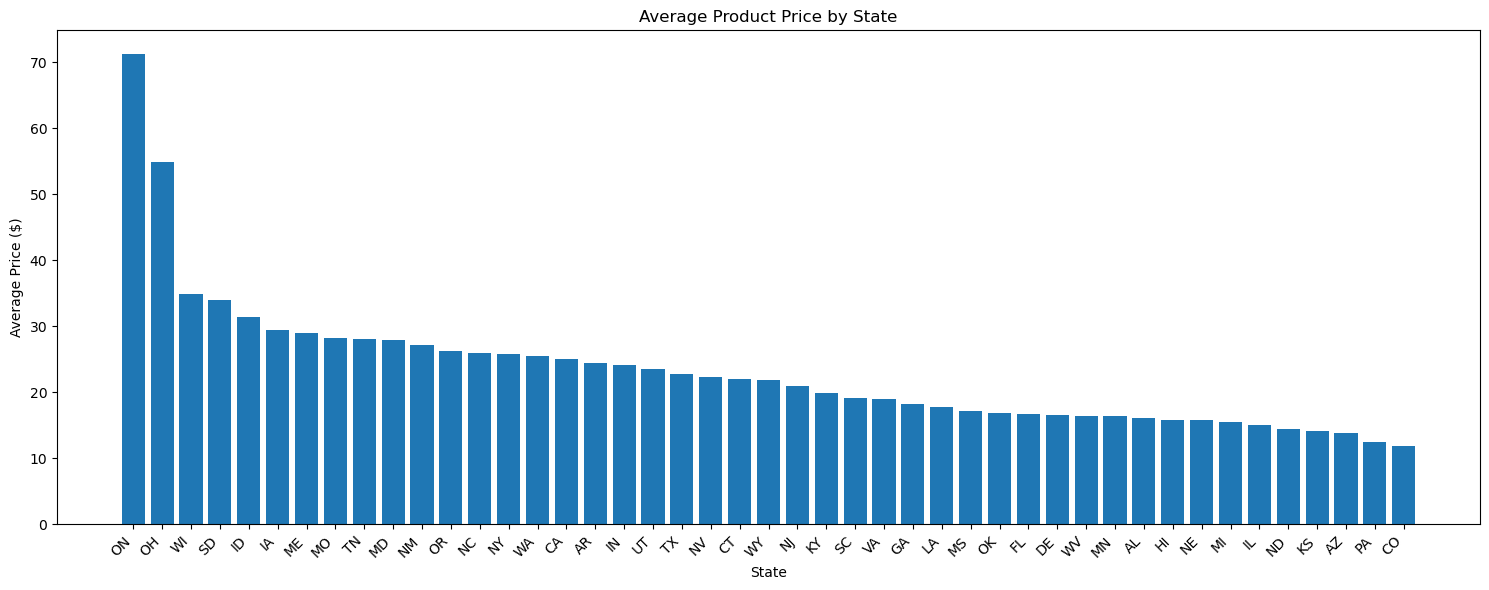

In [25]:
# Calculate average price by state
state_avg_prices = combined_df.groupby('pickupState')['currentPrice'].agg([
    'mean',
    'count',
    'min',
    'max'
]).round(2)

state_avg_prices = state_avg_prices.sort_values('mean', ascending=False)
print("Average Prices by State:")
print(state_avg_prices)

# Visualize average prices by state
plt.figure(figsize=(15, 6))
plt.bar(state_avg_prices.index, state_avg_prices['mean'])
plt.title('Average Product Price by State')
plt.xlabel('State')
plt.ylabel('Average Price ($)')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

In [26]:
# Get the most common category for each state
state_category_analysis = combined_df.groupby(['pickupState', 'mainCategory']).size().reset_index(name='count')
most_common_categories = state_category_analysis.loc[
    state_category_analysis.groupby('pickupState')['count'].idxmax()
]
most_common_categories = most_common_categories.sort_values('count', ascending=False)

# Display the results
print("Most Common Category in Each State:")
print(most_common_categories)

Most Common Category in Each State:
     pickupState         mainCategory   count
936           PA             Clothing  108221
711           NJ             Clothing   44449
536           MN             Clothing   44418
186           FL             Clothing   37413
1142          WA             Clothing   35892
94            CA             Clothing   25237
506           MI             Clothing   24537
1112          VA             Clothing   22021
906           OR             Clothing   21038
825           OH             Clothing   20666
1053          TX             Clothing   19353
356           IN             Clothing   18803
64            AZ             Clothing   16592
217           GA         Collectibles   11283
624           NC             Clothing   10585
127           CT             Clothing    7649
855           OK             Clothing    6272
966           SC             Clothing    6018
654           ND             Clothing    5349
327           IL         Collectibles    417

### graph analisis for art category

In [27]:
# Import required libraries
import pandas as pd
import numpy as np
from transformers import CLIPTokenizerFast, CLIPTextModel
import torch
import networkx as nx
import matplotlib.pyplot as plt

In [28]:
# Filter for Art category
art_df = combined_df[combined_df['mainCategory'] == 'Art'].copy()
print(f"Number of art items: {len(art_df)}")

Number of art items: 19930


In [29]:
# Load CLIP model for text embeddings
from tqdm.notebook import tqdm  # For Jupyter notebook
# or use: from tqdm import tqdm  # For regular Python

device = "cuda" if torch.cuda.is_available() else "cpu"
tokenizer = CLIPTokenizerFast.from_pretrained("openai/clip-vit-base-patch32")
text_encoder = CLIPTextModel.from_pretrained("openai/clip-vit-base-patch32").to(device)

# Function to get embeddings with truncation
def get_clip_embedding(text):
    inputs = tokenizer(
        text, 
        padding=True, 
        truncation=True,  # Add truncation
        max_length=77,    # Specify max length
        return_tensors="pt"
    ).to(device)
    outputs = text_encoder(**inputs)
    return outputs.pooler_output.detach().cpu().numpy()[0]

# Get embeddings for all descriptions with progress bar
embeddings = []
for title in tqdm(art_df['title'], desc="Generating CLIP embeddings", total=len(art_df)):
    embedding = get_clip_embedding(title)
    embeddings.append(embedding)

embeddings = np.array(embeddings)

/home/yuvalgor/.conda/envs/goodwill_proj/lib/python3.9/site-packages/huggingface_hub-0.27.0-py3.8.egg/huggingface_hub/file_download.py:795: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
/home/yuvalgor/.conda/envs/goodwill_proj/lib/python3.9/site-packages/transformers/modeling_utils.py:415: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mo

Generating CLIP embeddings:   0%|          | 0/19930 [00:00<?, ?it/s]

In [30]:
# Calculate cosine similarity between all pairs
from sklearn.metrics.pairwise import cosine_similarity
similarities = cosine_similarity(embeddings)

# Create graph with top 5 most similar neighbors for each node
G = nx.Graph()

# Add nodes with both description and imageUrl
for idx, row in enumerate(art_df.itertuples()):
    G.add_node(idx, 
               description=row.description,
               imageUrl=row.imageUrls,
               title=row.title,
               price=row.currentPrice)

# Add edges for top 5 most similar items (excluding self)
for i in tqdm(range(len(similarities)), desc="Creating edges"):
    # Create a mask to exclude the current node
    mask = np.ones(len(similarities), dtype=bool)
    mask[i] = False
    
    # Get indices of top 5 most similar items (excluding self)
    similar_indices = np.argsort(similarities[i][mask])[-5:]
    # Convert masked indices back to original indices
    original_indices = np.arange(len(similarities))[mask][similar_indices]
    
    # Add edges
    for j in original_indices:
        G.add_edge(i, j, weight=similarities[i][j])

print(f"Initial graph: {G.number_of_nodes()} nodes, {G.number_of_edges()} edges")
# Verify no self-loops
print(f"Number of self-loops: {len(list(nx.selfloop_edges(G)))}")

# Verify node attributes
print("\nSample node attributes:")
sample_node = list(G.nodes())[0]
print(f"Node {sample_node} attributes:", G.nodes[sample_node])

Creating edges:   0%|          | 0/19930 [00:00<?, ?it/s]

Initial graph: 19930 nodes, 79065 edges
Number of self-loops: 0

Sample node attributes:
Node 0 attributes: {'description': 'condition: good - shows signs of wear such has light surface scratches/scuffs, minor paint chipping, dirt and dust frame condition: fair - shows significant signs of wear such as scratches, paint chipping, stains, small cracks, etc. measurements are provided in the photos location: cleveland warehouse due to our lighting, white glare lines may appear on items - this is not damage if you have any questions regarding the quality or authenticity of this item, please email all inquiries prior to placing a bid. we are available to answer your questions monday through friday, 7:30 am - 3:00 pm, est. some items may contain unseen flaws not noted in the description. we are not experts in any field. see photos. items sold as-is. for combined shipping policy see the shipping tab.', 'imageUrl': 'https://shopgoodwillimages.azureedge.net/production/87/Items/11-26-2024/a10e7c6

In [31]:
# Function to prune graph to target size
def prune_to_size(G, target_size):
    G_pruned = G.copy()
    
    while G_pruned.number_of_nodes() > target_size:
        # Remove node with lowest degree
        degrees = dict(G_pruned.degree())
        min_degree_node = min(degrees, key=degrees.get)
        G_pruned.remove_node(min_degree_node)
    
    return G_pruned

# Prune to ~500 nodes
G_pruned = prune_to_size(G, 500)
print(f"Pruned graph: {G_pruned.number_of_nodes()} nodes, {G_pruned.number_of_edges()} edges")

Pruned graph: 500 nodes, 1956 edges


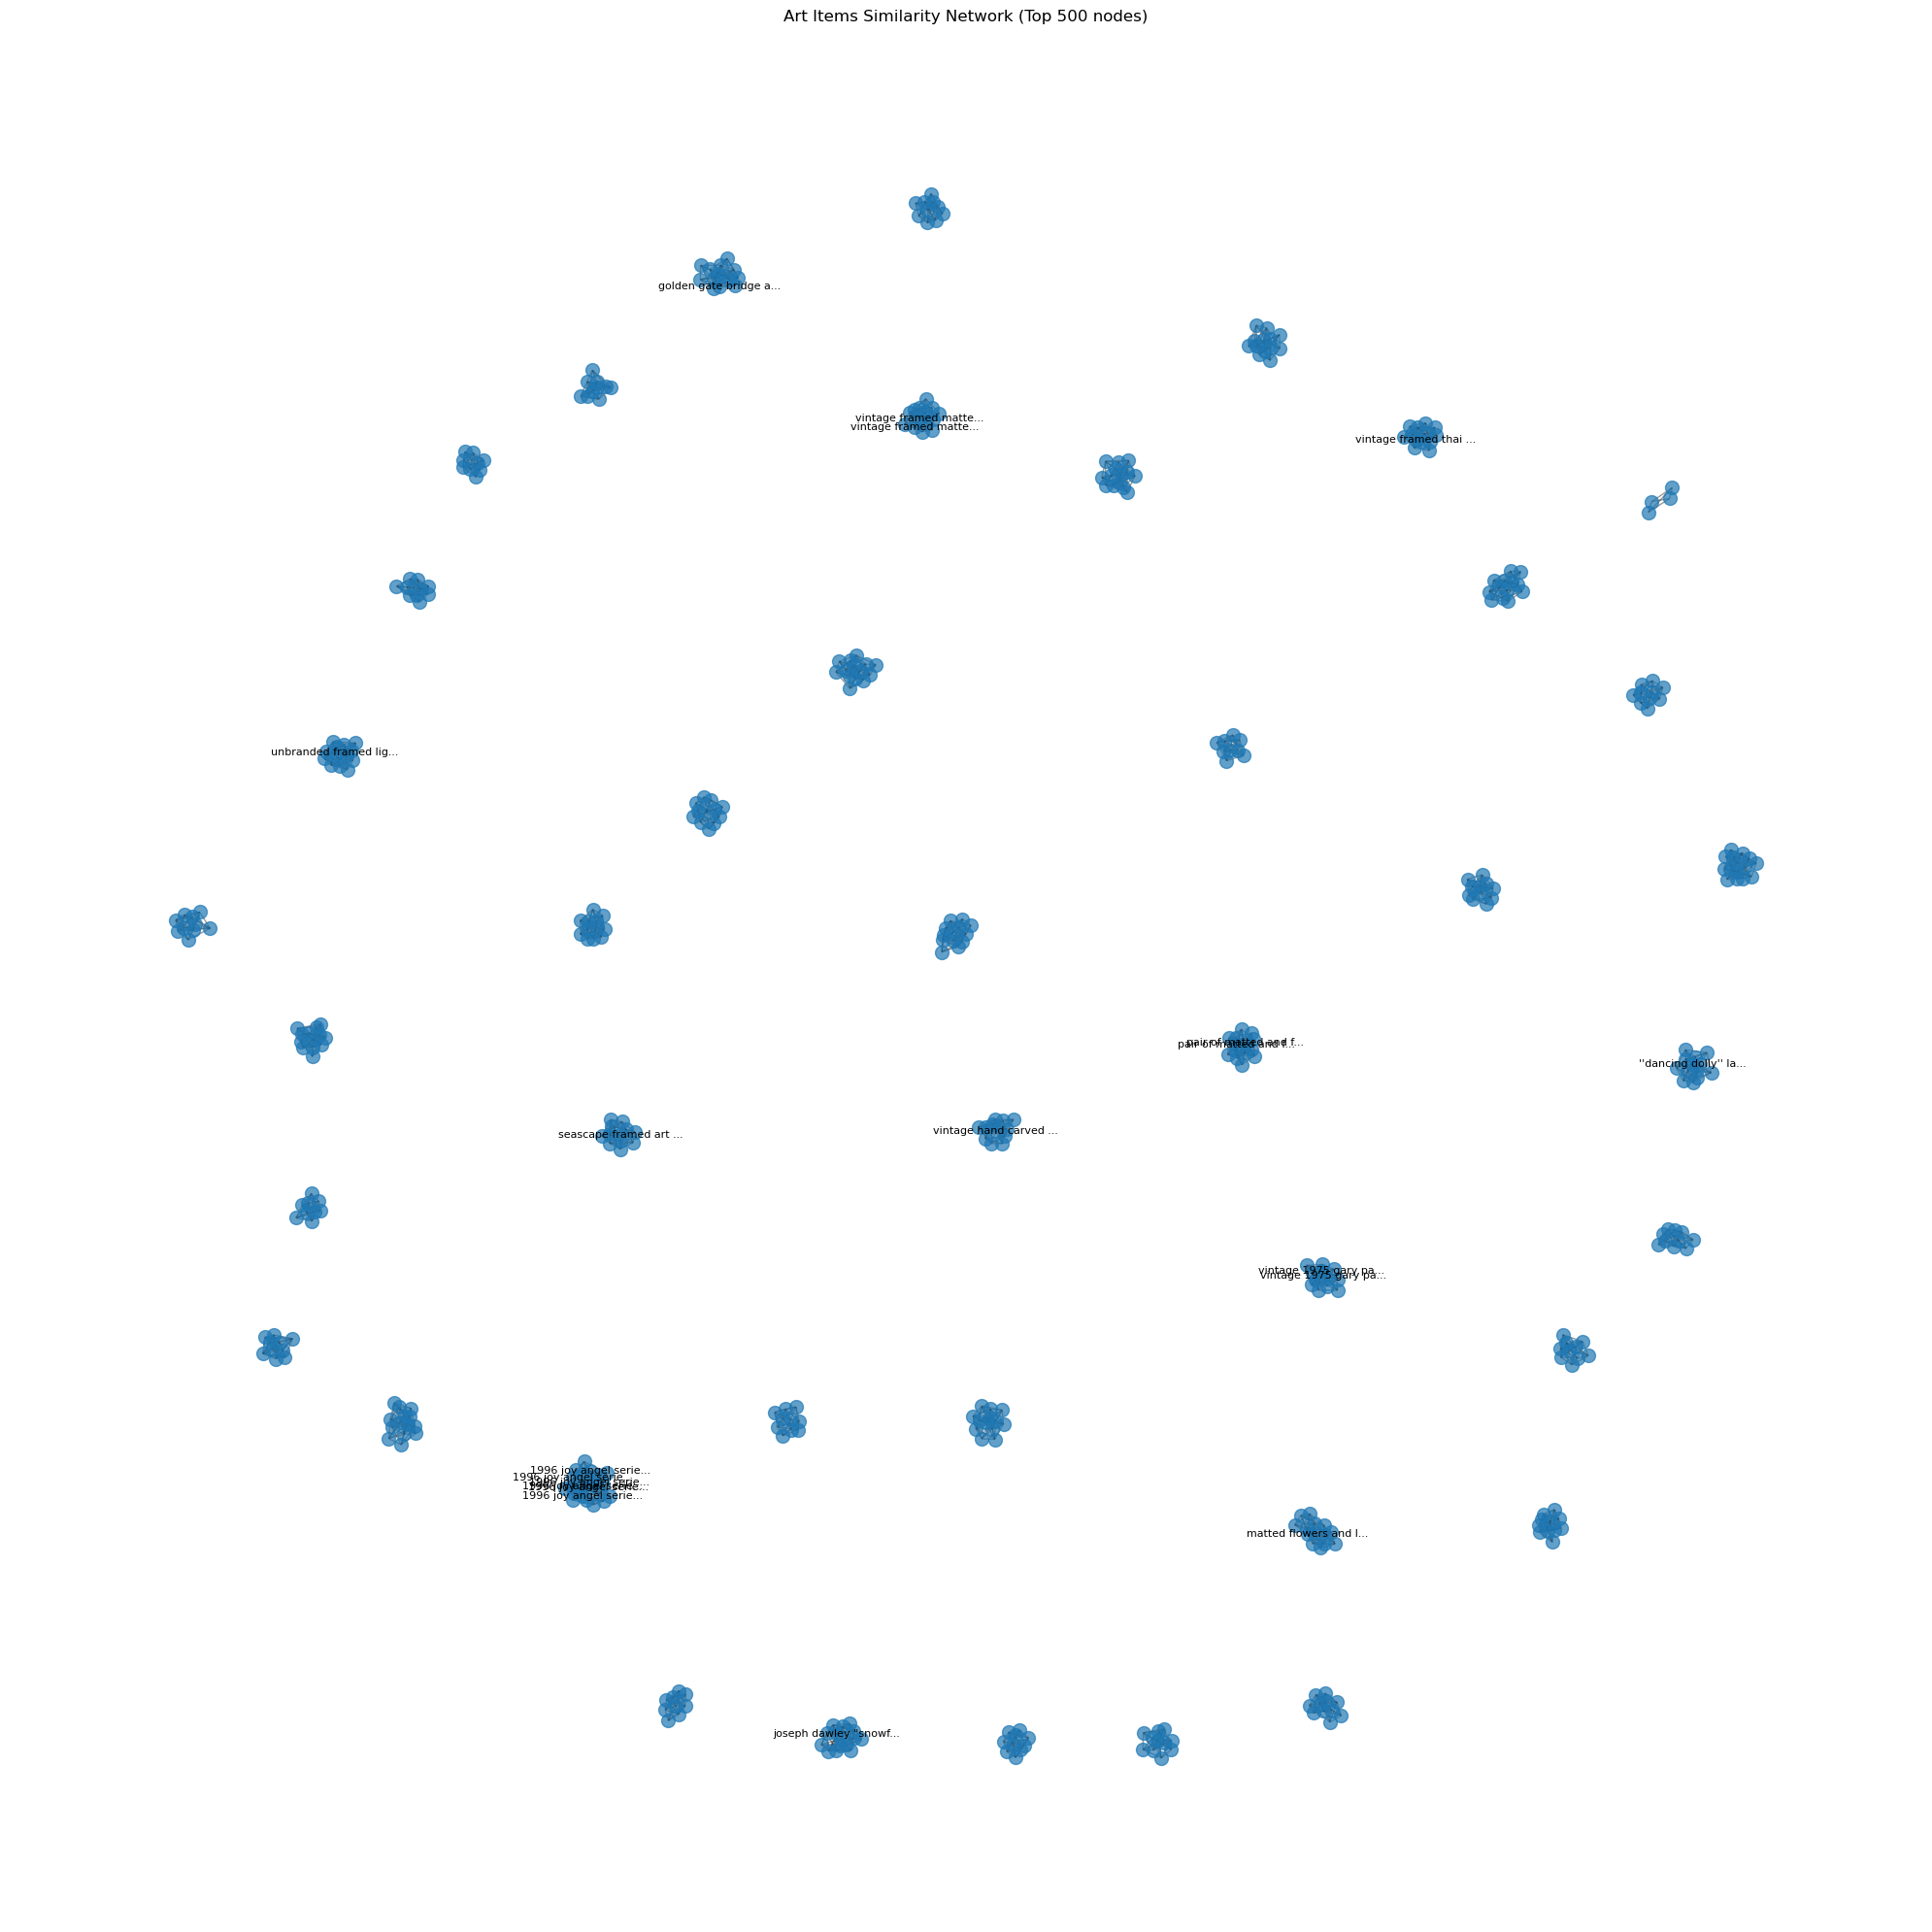

In [32]:
# Visualize using NetworkX with Graphviz layout
plt.figure(figsize=(20, 20))
pos = nx.spring_layout(G_pruned, k=1/np.sqrt(G_pruned.number_of_nodes()))

# Draw nodes
nx.draw_networkx_nodes(G_pruned, pos, node_size=100, alpha=0.7)

# Draw edges
nx.draw_networkx_edges(G_pruned, pos, alpha=0.4)

# Add labels for some nodes (top 20 by degree)
degrees = dict(G_pruned.degree())
top_nodes = sorted(degrees.items(), key=lambda x: x[1], reverse=True)[:20]
labels = {node: G_pruned.nodes[node]['title'][:20] + '...' 
          for node, _ in top_nodes}
nx.draw_networkx_labels(G_pruned, pos, labels, font_size=8)

plt.title("Art Items Similarity Network (Top 500 nodes)")
plt.axis('off')
plt.tight_layout()
plt.show()

In [33]:
# Print some statistics about the pruned graph
print("\nNetwork Statistics:")
print(f"Number of nodes: {G_pruned.number_of_nodes()}")
print(f"Number of edges: {G_pruned.number_of_edges()}")
print(f"Average degree: {sum(dict(G_pruned.degree()).values())/G_pruned.number_of_nodes():.2f}")
print("\nTop 10 items by degree (most connected):")
top_items = sorted(G_pruned.degree(), key=lambda x: x[1], reverse=True)[:10]
for node, degree in top_items:
    print(f"Degree {degree}: {G_pruned.nodes[node]['title']}")


Network Statistics:
Number of nodes: 500
Number of edges: 1956
Average degree: 7.82

Top 10 items by degree (most connected):
Degree 14: 1996 joy angel series cookie mold longaberger pottery iob
Degree 12: 1996 joy angel series cookie mold longaberger pottery iob
Degree 12: 1996 joy angel series cookie mold longaberger pottery iob
Degree 12: vintage framed matted and signed art print
Degree 11: pair of matted and framed rose and child themed prints
Degree 11: unbranded framed lighthouse on the ocean print
Degree 11: ''dancing dolly'' laurel & hardy repro print by mary stephenson framed & matted
Degree 11: pair of matted and framed rose and child themed prints
Degree 11: 1996 joy angel series cookie mold longaberger pottery iob
Degree 11: 1996 joy angel series cookie mold longaberger pottery iob


In [45]:
# Find connected components of pruned graph
connected_components = list(nx.connected_components(G_pruned))
connected_components = sorted(connected_components, key=len, reverse=True)
print(f"Number of connected components: {len(connected_components)}")
print("Component sizes:", [len(comp) for comp in connected_components])

# Get the largest component
largest_component = G_pruned.subgraph(connected_components[1])
print(f"\nLargest component has {len(largest_component)} nodes")

Number of connected components: 42
Component sizes: [22, 15, 15, 14, 14, 14, 14, 14, 14, 14, 14, 13, 13, 13, 13, 13, 13, 13, 13, 12, 12, 12, 12, 11, 11, 11, 11, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 9, 9, 9, 9, 4]

Largest component has 15 nodes


Displaying images from largest component (15 nodes)


Loading images: 100%|██████████| 15/15 [00:08<00:00,  1.80it/s]


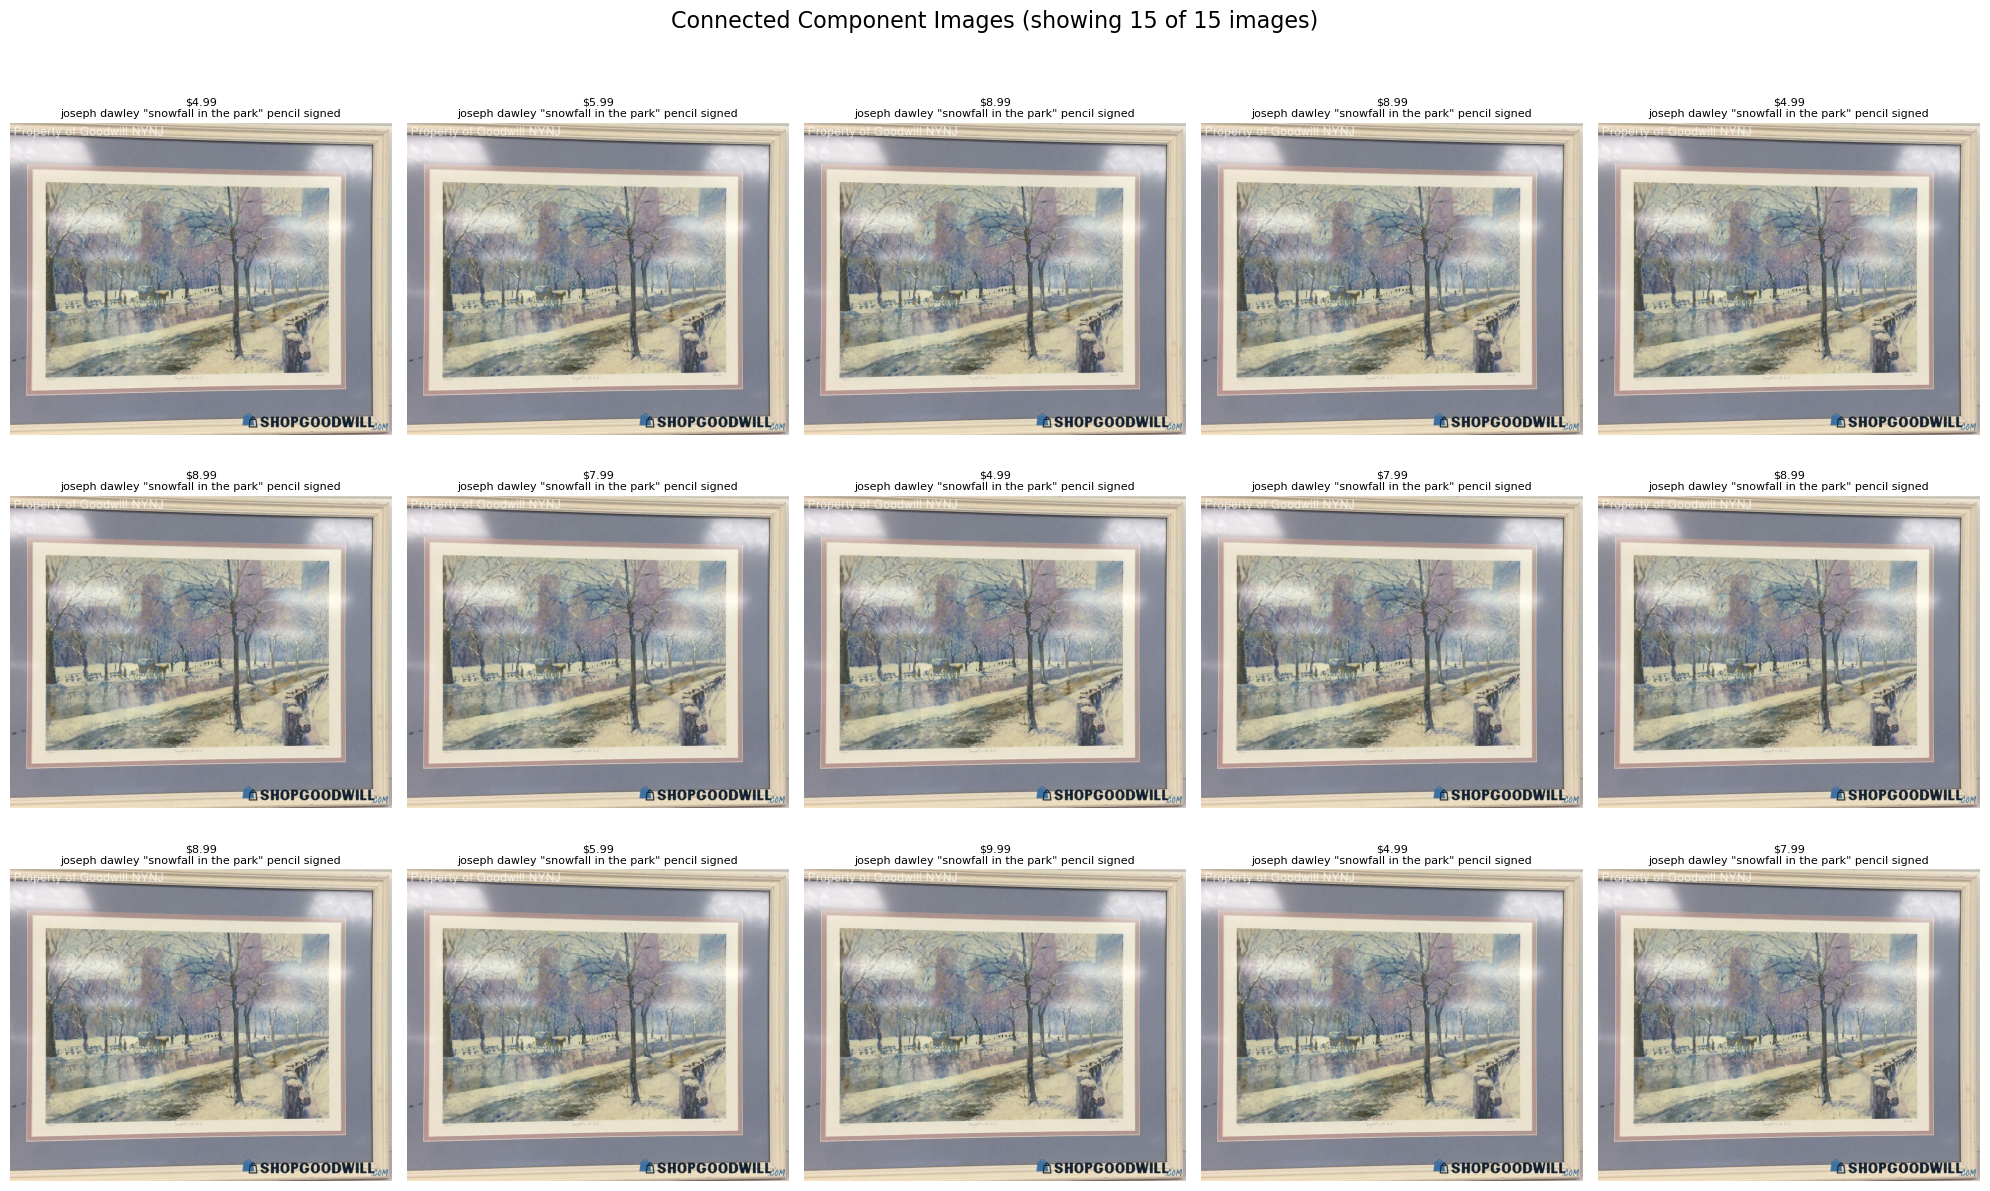

In [46]:
import matplotlib.pyplot as plt
import requests
from PIL import Image as PILImage
from io import BytesIO
import math
from tqdm import tqdm

def plot_component_images(G, component, max_images=25):
    """
    Plot images from a network component in a grid layout.
    
    Args:
        G: NetworkX graph
        component: List of nodes in the component
        max_images: Maximum number of images to display
    """
    # Get nodes and limit number of images
    nodes = list(component)[:max_images]
    num_images = len(nodes)
    
    # Calculate grid dimensions
    cols = min(5, num_images)
    rows = math.ceil(num_images / cols)
    
    # Create subplot grid
    fig = plt.figure(figsize=(4*cols, 4*rows))
    
    # Plot images with progress bar
    for idx, node in enumerate(tqdm(nodes, desc="Loading images")):
        ax = fig.add_subplot(rows, cols, idx+1)
        try:
            # Get image URL and metadata
            img_url = G.nodes[node]['imageUrl']
            price = G.nodes[node].get('price', 'N/A')
            title = G.nodes[node].get('title', '')[:50]
            
            # Download and display image
            response = requests.get(img_url, timeout=5)
            img = PILImage.open(BytesIO(response.content)).convert('RGB')
            ax.imshow(img)
            ax.axis('off')
            
            # Set title with price and item name
            title_text = f'${price}\n{title}'
            ax.set_title(title_text, size=8, wrap=True)
            
        except Exception as e:
            print(f"Error loading image {idx}: {str(e)}")
            # Create a red background for error indication
            ax.set_facecolor('mistyrose')
            ax.text(0.5, 0.5, 'Error loading\nimage', 
                   ha='center', 
                   va='center',
                   color='red',
                   size=8,
                   wrap=True)
            ax.axis('off')
    
    # Add overall title
    plt.suptitle(f'Connected Component Images (showing {num_images} of {len(component)} images)', 
                size=16, 
                y=1.02)
    
    # Adjust layout
    plt.tight_layout()
    plt.show()

# Example usage:
print(f"Displaying images from largest component ({len(largest_component)} nodes)")
plot_component_images(G_pruned, largest_component)

## graph with image embeddings 

In [47]:
import torch
from transformers import CLIPTokenizerFast, CLIPTextModel
from transformers import CLIPProcessor, CLIPModel
import numpy as np
from tqdm import tqdm
import networkx as nx
from PIL import Image as PILImage
import requests
from io import BytesIO
from sklearn.metrics.pairwise import cosine_similarity

In [53]:
# 1. Filter and prepare the data
# Filter for Jewelry & Gemstones category and remove duplicates by title
jewelry_df = combined_df[combined_df['mainCategory'] == 'Jewelry & Gemstones'].copy()
jewelry_df = jewelry_df.drop_duplicates(subset=['title'])
# Take first 10,000 rows
jewelry_df = jewelry_df.head(500)
print(f"Number of jewelry items after filtering: {len(jewelry_df)}")


Number of jewelry items after filtering: 500


In [54]:
device = "cuda" if torch.cuda.is_available() else "cpu"
# For text embeddings
tokenizer = CLIPTokenizerFast.from_pretrained("openai/clip-vit-base-patch32")
text_encoder = CLIPTextModel.from_pretrained("openai/clip-vit-base-patch32").to(device)
# For image embeddings
clip_model = CLIPModel.from_pretrained("openai/clip-vit-base-patch32").to(device)
processor = CLIPProcessor.from_pretrained("openai/clip-vit-base-patch32")

Some weights of the model checkpoint at openai/clip-vit-base-patch32 were not used when initializing CLIPTextModel: ['vision_model.encoder.layers.9.self_attn.k_proj.bias', 'vision_model.encoder.layers.5.self_attn.v_proj.bias', 'vision_model.encoder.layers.3.mlp.fc2.weight', 'vision_model.encoder.layers.4.mlp.fc2.weight', 'vision_model.encoder.layers.10.layer_norm2.bias', 'vision_model.encoder.layers.0.layer_norm2.weight', 'vision_model.encoder.layers.9.layer_norm1.weight', 'vision_model.encoder.layers.6.layer_norm2.weight', 'vision_model.encoder.layers.11.self_attn.v_proj.bias', 'vision_model.encoder.layers.7.self_attn.k_proj.weight', 'vision_model.encoder.layers.6.self_attn.k_proj.weight', 'vision_model.encoder.layers.7.layer_norm1.bias', 'vision_model.encoder.layers.3.layer_norm2.weight', 'vision_model.encoder.layers.6.layer_norm2.bias', 'vision_model.encoder.layers.11.self_attn.q_proj.weight', 'vision_model.encoder.layers.9.self_attn.q_proj.bias', 'vision_model.encoder.layers.10.lay

In [55]:
# 3. Function to get text embeddings
def get_clip_text_embedding(text):
    inputs = tokenizer(
        text, 
        padding=True, 
        truncation=True,
        max_length=77,
        return_tensors="pt"
    ).to(device)
    outputs = text_encoder(**inputs)
    return outputs.pooler_output.detach().cpu().numpy()[0]

# 4. Function to get image embeddings
def get_clip_image_embedding(image_url):
    try:
        response = requests.get(image_url, timeout=5)
        image = PILImage.open(BytesIO(response.content)).convert('RGB')
        inputs = processor(images=image, return_tensors="pt").to(device)
        outputs = clip_model.get_image_features(**inputs)
        return outputs.detach().cpu().numpy()[0]
    except Exception as e:
        print(f"Error processing image: {str(e)}")
        return np.zeros(512)  # Return zero vector in case of error


In [56]:
# 5. Generate embeddings
print("Generating text embeddings...")
text_embeddings = []
for title in tqdm(jewelry_df['title'], desc="Generating text embeddings"):
    embedding = get_clip_text_embedding(title)
    text_embeddings.append(embedding)
text_embeddings = np.array(text_embeddings)

Generating text embeddings...


Generating text embeddings: 100%|██████████| 500/500 [00:04<00:00, 121.60it/s]


In [57]:
print("Generating image embeddings...")
image_embeddings = []
for url in tqdm(jewelry_df['imageUrls'], desc="Generating image embeddings"):
    embedding = get_clip_image_embedding(url)
    image_embeddings.append(embedding)
image_embeddings = np.array(image_embeddings)

Generating image embeddings...


Generating image embeddings: 100%|██████████| 500/500 [04:11<00:00,  1.99it/s]


In [58]:
# 6. Calculate combined similarity
def calculate_combined_similarity(text_emb, image_emb):
    text_sim = cosine_similarity(text_emb)
    image_sim = cosine_similarity(image_emb)
    return (text_sim + image_sim) / 2

similarity_matrix = calculate_combined_similarity(text_embeddings, image_embeddings)

In [59]:
# 7. Create network graph
G = nx.Graph()

# Add nodes
for idx, row in jewelry_df.iterrows():
    G.add_node(idx, 
               title=row['title'],
               imageUrl=row['imageUrls'],
               price=row.get('price', 'N/A'))

# Add edges for 3 closest neighbors
k_neighbors = 3
for i in range(len(similarity_matrix)):
    # Get indices of k highest similarities (excluding self)
    similar_indices = np.argsort(similarity_matrix[i])[-k_neighbors-1:-1][::-1]
    for j in similar_indices:
        if i != j:  # Avoid self-loops
            G.add_edge(i, j, weight=similarity_matrix[i][j])



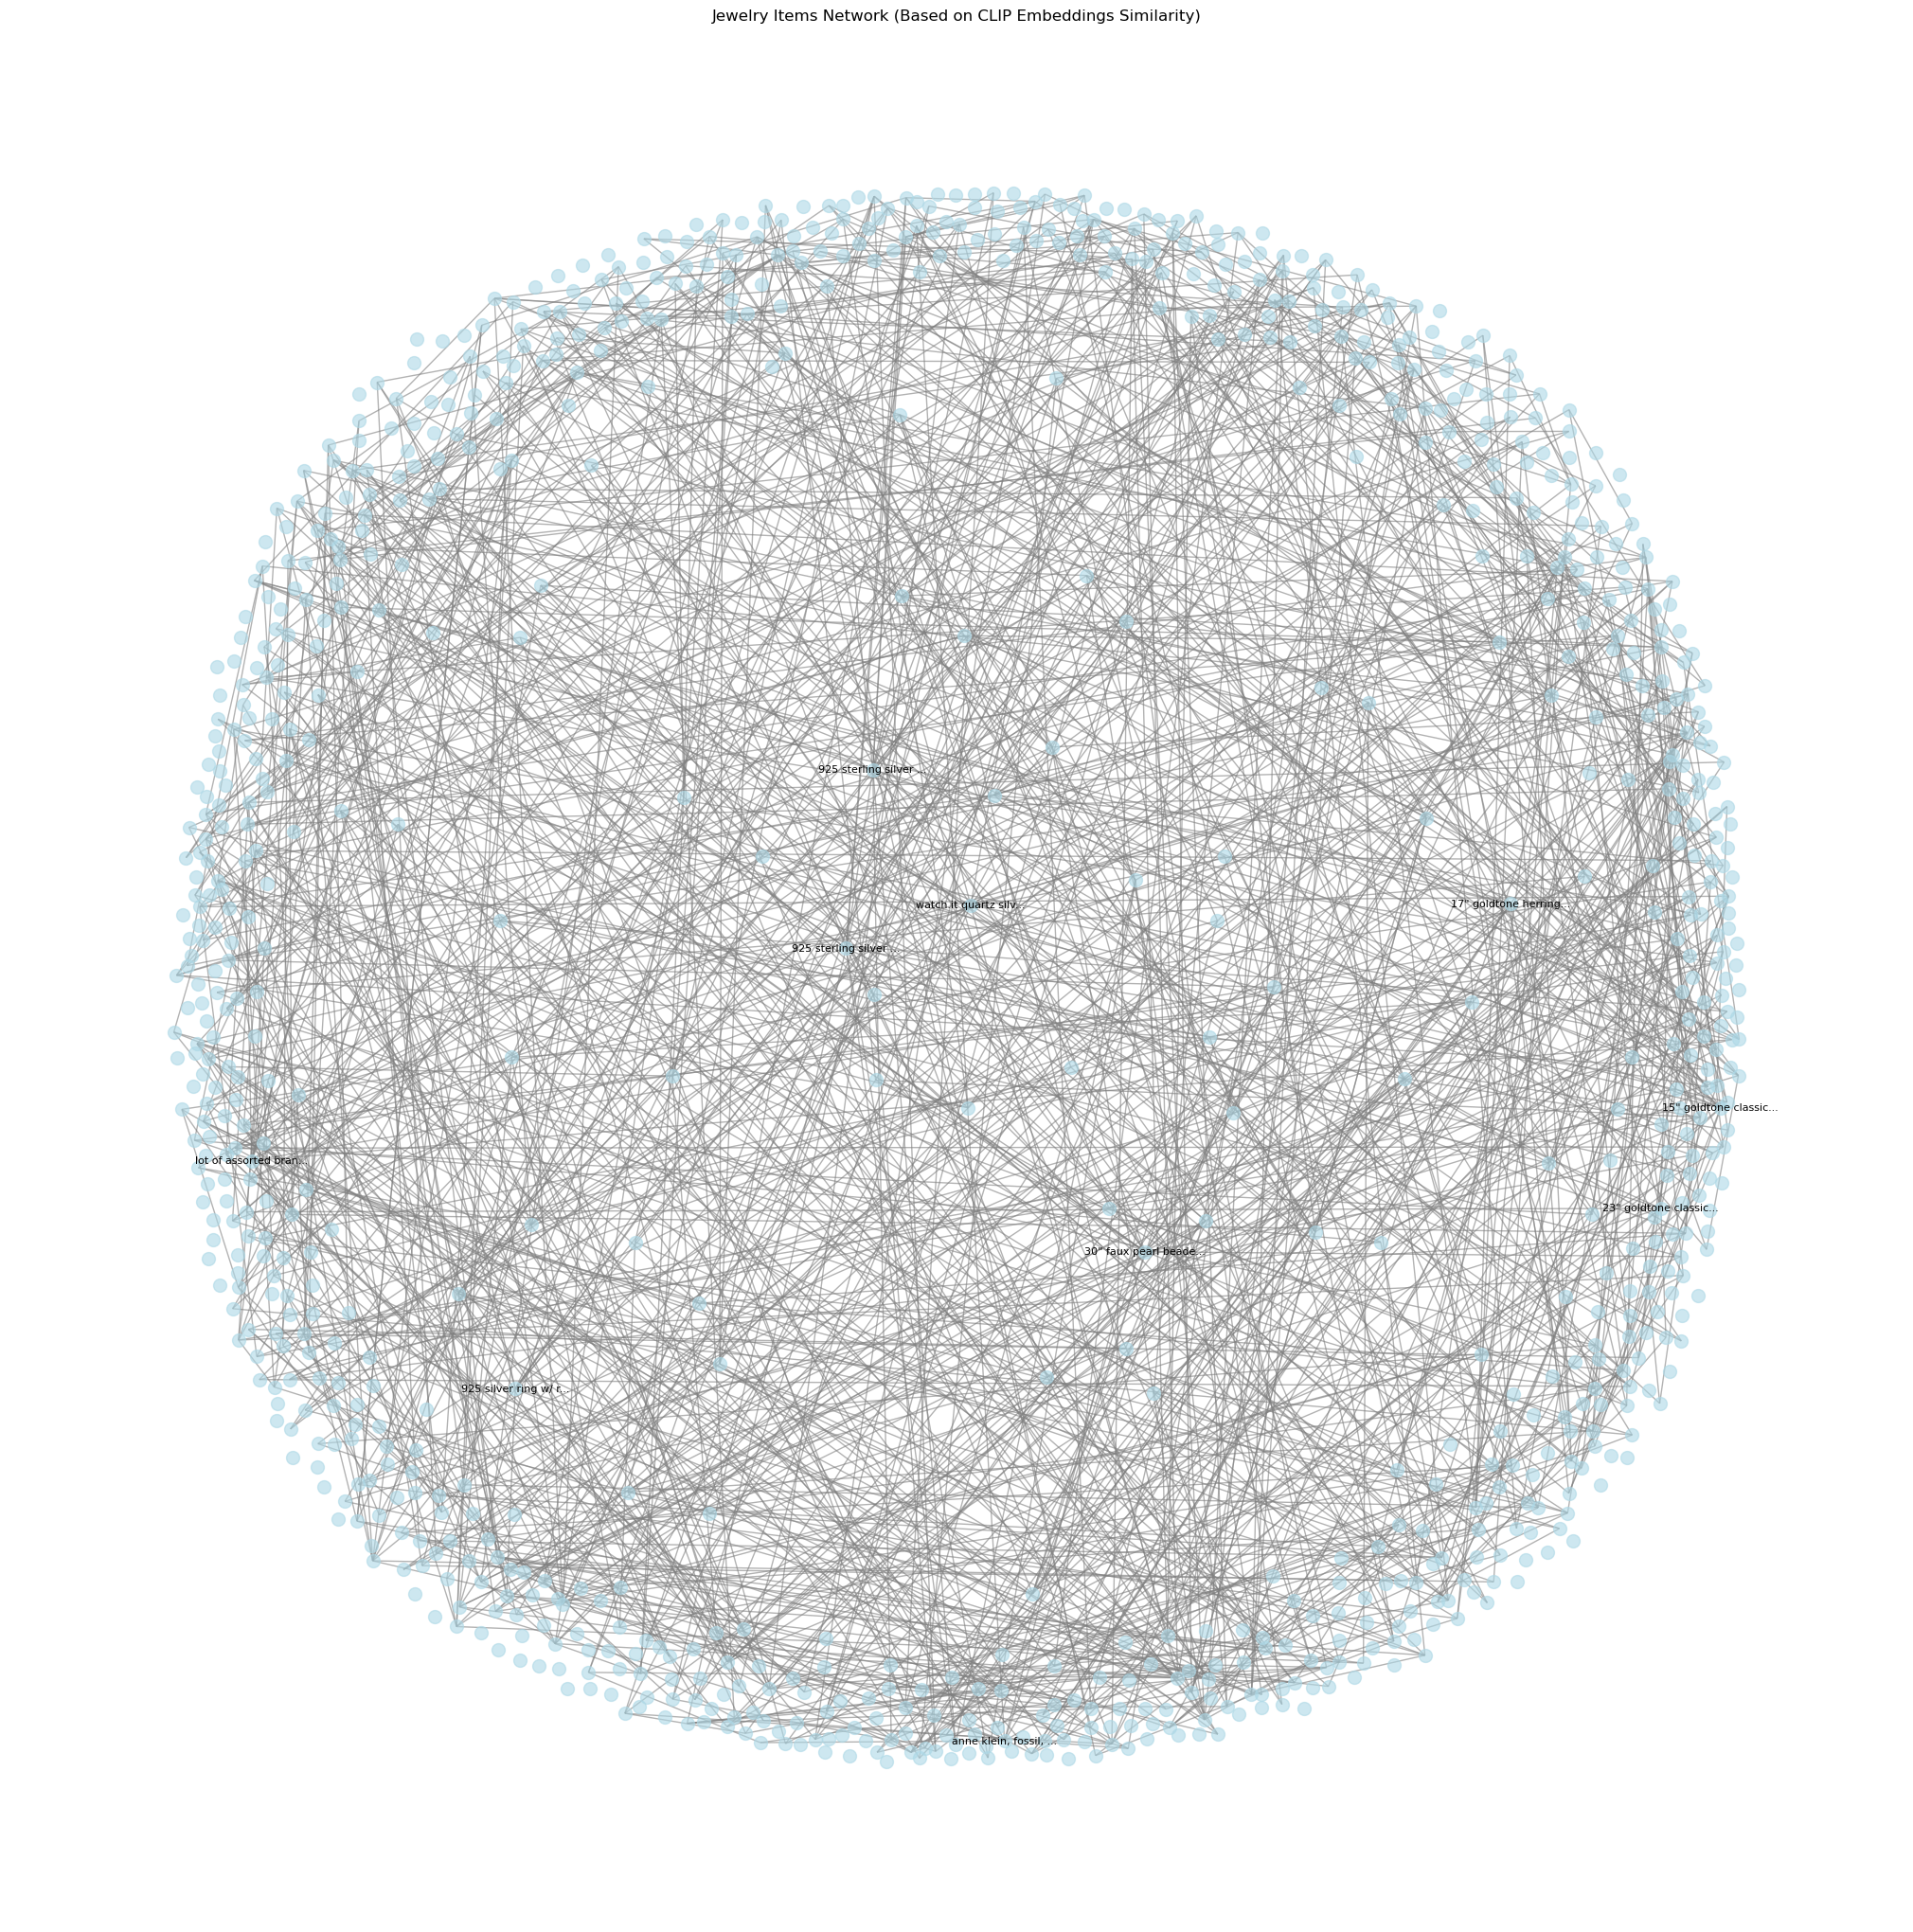


Network Statistics:
Number of nodes: 958
Number of edges: 1179
Average degree: 2.46


In [60]:
# 8. Visualize the network
plt.figure(figsize=(20, 20))
pos = nx.spring_layout(G, k=1, iterations=50)
nx.draw(G, pos,
        node_size=100,
        node_color='lightblue',
        edge_color='gray',
        alpha=0.6,
        with_labels=False)

# Add some labels for largest nodes
degrees = dict(G.degree())
largest_nodes = sorted(degrees.items(), key=lambda x: x[1], reverse=True)[:10]
labels = {node: jewelry_df.iloc[node]['title'][:20] + '...' 
         for node, degree in largest_nodes}
nx.draw_networkx_labels(G, pos, labels, font_size=8)

plt.title("Jewelry Items Network (Based on CLIP Embeddings Similarity)")
plt.show()

# Print some statistics
print("\nNetwork Statistics:")
print(f"Number of nodes: {G.number_of_nodes()}")
print(f"Number of edges: {G.number_of_edges()}")
print(f"Average degree: {sum(degrees.values()) / len(degrees):.2f}")


Removed 939 nodes with degree < 10


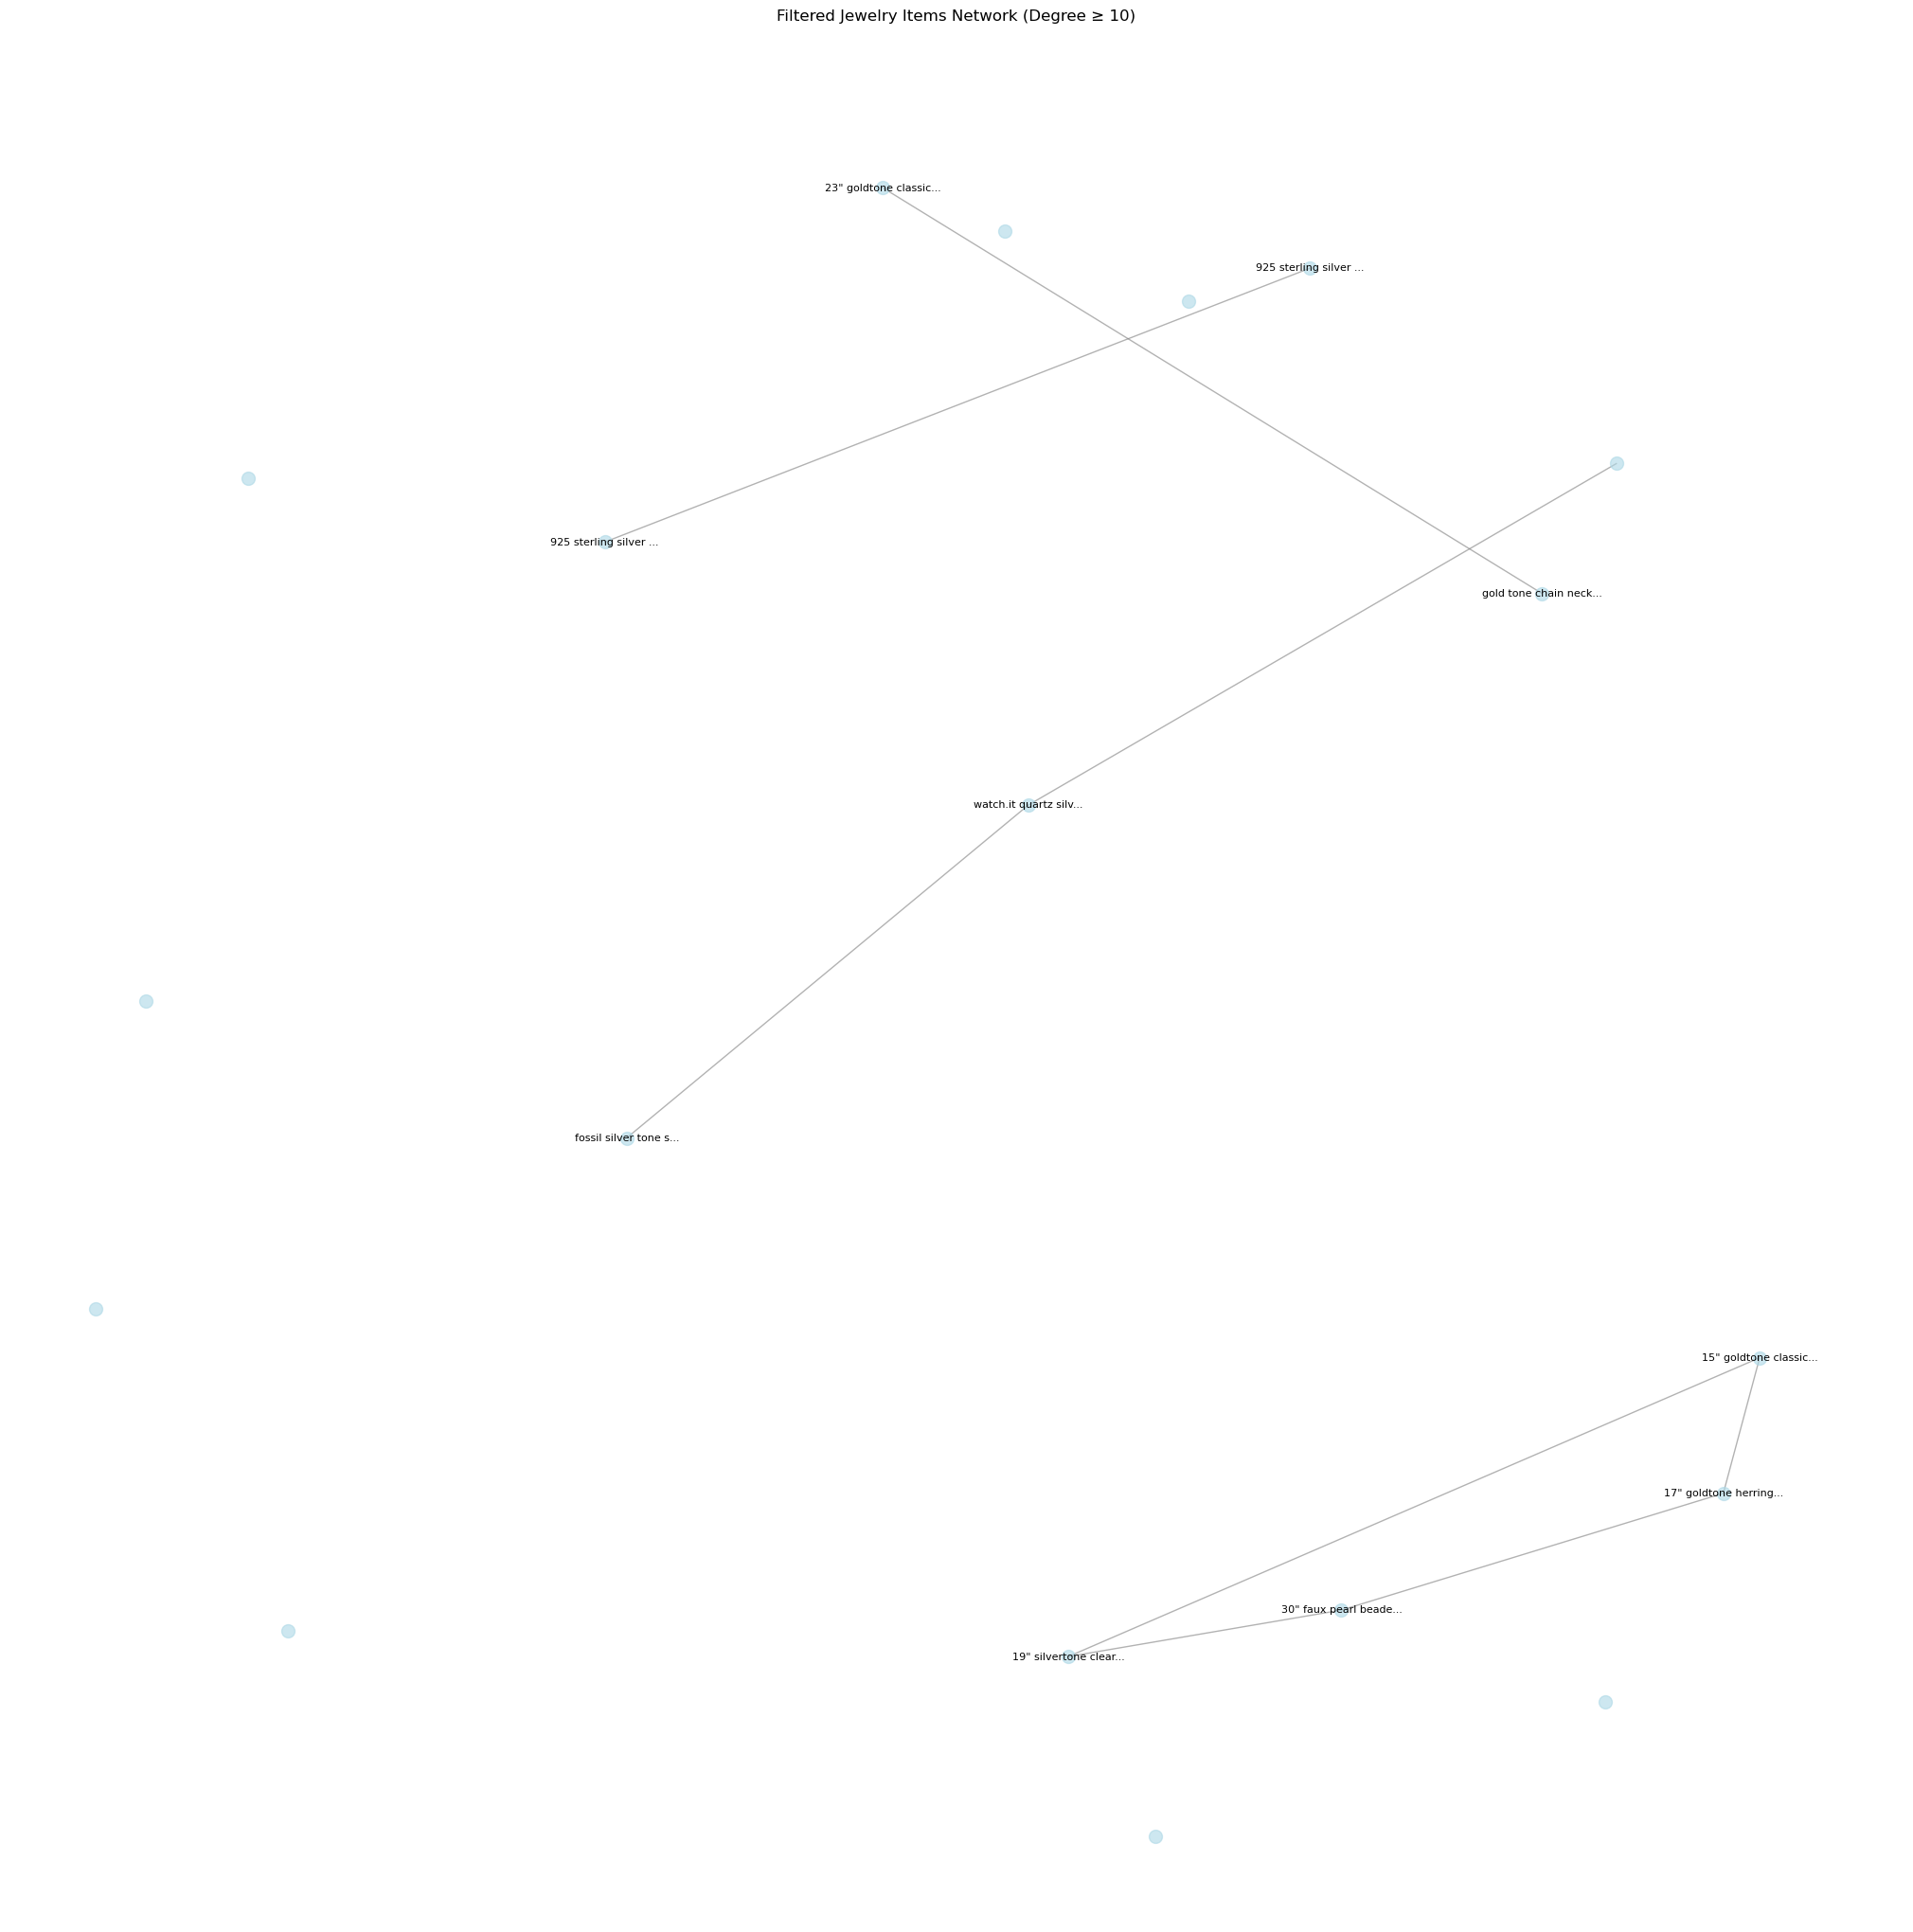


Filtered Network Statistics:
Number of nodes: 19
Number of edges: 8
Average degree: 0.84

Number of connected components: 12
Largest component size: 4


In [65]:
# Create network graph with minimum degree filtering
def create_filtered_network(similarity_matrix, jewelry_df, min_degree=10, k_neighbors=3):
    # First create the full graph
    G = nx.Graph()
    
    # Add nodes
    for idx, row in jewelry_df.iterrows():
        G.add_node(idx, 
                   title=row['title'],
                   imageUrl=row['imageUrls'],
                   price=row.get('price', 'N/A'))

    # Add edges for k closest neighbors
    for i in range(len(similarity_matrix)):
        # Get indices of k highest similarities (excluding self)
        similar_indices = np.argsort(similarity_matrix[i])[-k_neighbors-1:-1][::-1]
        for j in similar_indices:
            if i != j:  # Avoid self-loops
                G.add_edge(i, j, weight=similarity_matrix[i][j])

    # Remove nodes with degree less than min_degree
    nodes_to_remove = [node for node, degree in dict(G.degree()).items() if degree < min_degree]
    G.remove_nodes_from(nodes_to_remove)
    
    print(f"Removed {len(nodes_to_remove)} nodes with degree < {min_degree}")
    
    return G

# Create the filtered graph
min_degree = 10
G_filtered = create_filtered_network(similarity_matrix, jewelry_df, min_degree=min_degree, k_neighbors=3)

# Visualize the filtered network
plt.figure(figsize=(20, 20))
pos = nx.spring_layout(G_filtered, k=1, iterations=50)

# Draw the network
nx.draw(G_filtered, pos,
        node_size=100,
        node_color='lightblue',
        edge_color='gray',
        alpha=0.6,
        with_labels=False)

# Add labels for largest nodes
degrees = dict(G_filtered.degree())
largest_nodes = sorted(degrees.items(), key=lambda x: x[1], reverse=True)[:10]
labels = {node: jewelry_df.iloc[node]['title'][:20] + '...' 
         for node, degree in largest_nodes}
nx.draw_networkx_labels(G_filtered, pos, labels, font_size=8)

plt.title(f"Filtered Jewelry Items Network (Degree ≥ {min_degree})")
plt.show()

# Print network statistics
print("\nFiltered Network Statistics:")
print(f"Number of nodes: {G_filtered.number_of_nodes()}")
print(f"Number of edges: {G_filtered.number_of_edges()}")
print(f"Average degree: {sum(degrees.values()) / len(degrees):.2f}")

# To get the components of the filtered graph
components = list(nx.connected_components(G_filtered))
print(f"\nNumber of connected components: {len(components)}")
print(f"Largest component size: {len(max(components, key=len))}")

Displaying images from largest component (4 nodes)


Loading images: 100%|██████████| 4/4 [00:01<00:00,  2.92it/s]


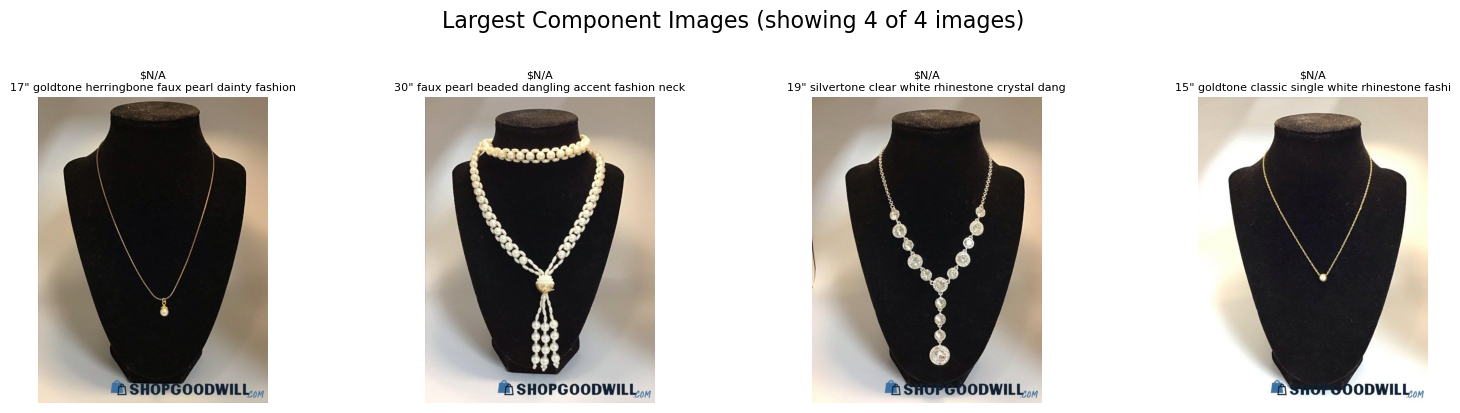


Sample items from largest component:

Title: 17" goldtone herringbone faux pearl dainty fashion necklace
Price: $N/A
Degree: 2

Title: 30" faux pearl beaded dangling accent fashion necklace
Price: $N/A
Degree: 2

Title: 19" silvertone clear white rhinestone crystal dangling fashion necklace
Price: $N/A
Degree: 2

Title: 15" goldtone classic single white rhinestone fashion necklace
Price: $N/A
Degree: 2


In [66]:
import matplotlib.pyplot as plt
import requests
from PIL import Image as PILImage
from io import BytesIO
import math
from tqdm import tqdm

def plot_component_images(G, component, jewelry_df, max_images=25):
    """
    Plot images from a network component in a grid layout.
    
    Args:
        G: NetworkX graph
        component: Set of nodes in the component
        jewelry_df: Original dataframe with image URLs
        max_images: Maximum number of images to display
    """
    # Get nodes and limit number of images
    nodes = list(component)[:max_images]
    num_images = len(nodes)
    
    # Calculate grid dimensions
    cols = min(5, num_images)
    rows = math.ceil(num_images / cols)
    
    # Create subplot grid
    fig = plt.figure(figsize=(4*cols, 4*rows))
    
    # Plot images with progress bar
    for idx, node in enumerate(tqdm(nodes, desc="Loading images")):
        ax = fig.add_subplot(rows, cols, idx+1)
        try:
            # Get image URL and metadata
            img_url = jewelry_df.iloc[node]['imageUrls']
            price = jewelry_df.iloc[node].get('price', 'N/A')
            title = jewelry_df.iloc[node].get('title', '')[:50]
            
            # Download and display image
            response = requests.get(img_url, timeout=5)
            img = PILImage.open(BytesIO(response.content)).convert('RGB')
            ax.imshow(img)
            ax.axis('off')
            
            # Set title with price and item name
            title_text = f'${price}\n{title}'
            ax.set_title(title_text, size=8, wrap=True)
            
        except Exception as e:
            print(f"Error loading image {idx}: {str(e)}")
            # Create a red background for error indication
            ax.set_facecolor('mistyrose')
            ax.text(0.5, 0.5, 'Error loading\nimage', 
                   ha='center', 
                   va='center',
                   color='red',
                   size=8,
                   wrap=True)
            ax.axis('off')
    
    # Add overall title
    plt.suptitle(f'Largest Component Images (showing {num_images} of {len(component)} images)', 
                size=16, 
                y=1.02)
    
    # Adjust layout
    plt.tight_layout()
    plt.show()

# Get the largest component
largest_component = max(nx.connected_components(G_filtered), key=len)

# Display images from largest component
print(f"Displaying images from largest component ({len(largest_component)} nodes)")
plot_component_images(G_filtered, largest_component, jewelry_df)

# Print some statistics about the items in the largest component
print("\nSample items from largest component:")
for node in list(largest_component)[:5]:  # Show first 5 items
    print(f"\nTitle: {jewelry_df.iloc[node]['title']}")
    print(f"Price: ${jewelry_df.iloc[node].get('price', 'N/A')}")
    print(f"Degree: {G_filtered.degree[node]}")

## graph analizing

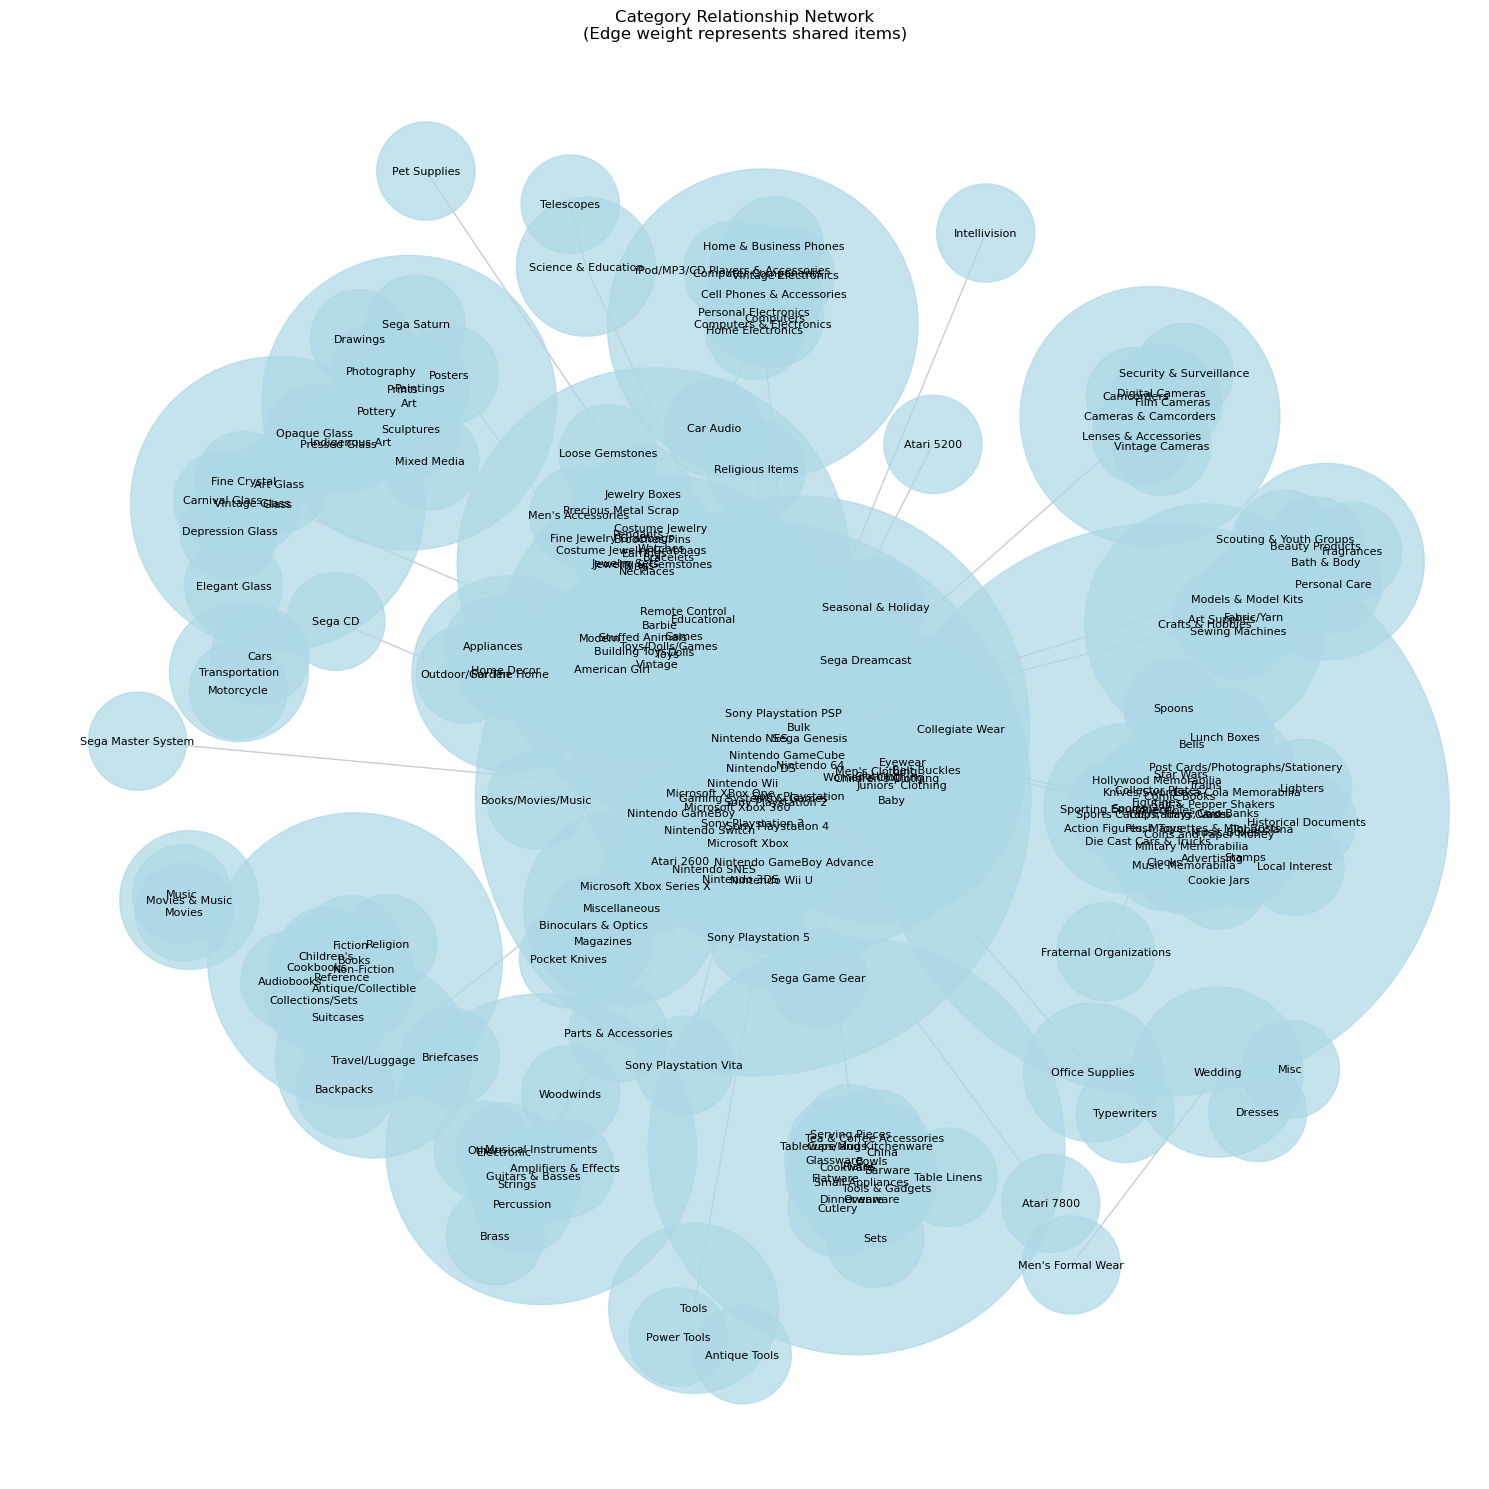

In [67]:
def create_category_network(df, min_weight=5):
    """Create a network of categories connected by shared items."""
    G = nx.Graph()
    
    # Create edges between main categories and subcategories
    category_pairs = df[['mainCategory', 'subCategory']].drop_duplicates()
    for _, row in category_pairs.iterrows():
        weight = len(df[(df['mainCategory'] == row['mainCategory']) & 
                       (df['subCategory'] == row['subCategory'])])
        if weight >= min_weight:
            G.add_edge(row['mainCategory'], row['subCategory'], weight=weight)
    
    return G

# Create and visualize category network
category_graph = create_category_network(combined_df)

plt.figure(figsize=(15, 15))
pos = nx.spring_layout(category_graph, k=1, iterations=50)

# Calculate node sizes based on degree centrality
node_size = [5000 * category_graph.degree(node) for node in category_graph.nodes()]

# Draw the network
nx.draw_networkx_nodes(category_graph, pos, node_size=node_size, 
                      node_color='lightblue', alpha=0.7)
nx.draw_networkx_edges(category_graph, pos, alpha=0.2)
nx.draw_networkx_labels(category_graph, pos, font_size=8)

plt.title('Category Relationship Network\n(Edge weight represents shared items)')
plt.axis('off')
plt.tight_layout()
plt.show()

In [68]:
print("Category Network Metrics:")
print(f"Number of nodes: {category_graph.number_of_nodes()}")
print(f"Number of edges: {category_graph.number_of_edges()}")
print(f"Average clustering coefficient: {nx.average_clustering(category_graph):.3f}")
print(f"Network density: {nx.density(category_graph):.3f}")

# Most central categories
centrality = nx.degree_centrality(category_graph)
top_categories = sorted(centrality.items(), key=lambda x: x[1], reverse=True)[:10]
print("\nTop 10 most connected categories:")
for cat, cent in top_categories:
    print(f"{cat}: {cent:.3f}")

Category Network Metrics:
Number of nodes: 223
Number of edges: 217
Average clustering coefficient: 0.002
Network density: 0.009

Top 10 most connected categories:
Collectibles: 0.153
Gaming Systems & Games: 0.144
Bulk: 0.099
Tableware and Kitchenware: 0.081
Jewelry & Gemstones: 0.072
Toys/Dolls/Games: 0.054
Computers & Electronics: 0.045
Musical Instruments: 0.045
Clothing: 0.041
Books: 0.041


In [69]:
def create_seller_network(df, min_shared_categories=2):
    """Create a network of sellers connected by shared category listings."""
    G = nx.Graph()
    
    # Create seller-category dictionary
    seller_categories = defaultdict(set)
    for _, row in df.iterrows():
        seller_categories[row['sellerCompanyName']].add(row['mainCategory'])
    
    # Create edges between sellers with shared categories
    sellers = list(seller_categories.keys())
    for i in range(len(sellers)):
        for j in range(i+1, len(sellers)):
            shared_cats = len(seller_categories[sellers[i]] & 
                            seller_categories[sellers[j]])
            if shared_cats >= min_shared_categories:
                G.add_edge(sellers[i], sellers[j], weight=shared_cats)
    
    return G

# Create and visualize seller network
seller_graph = create_seller_network(combined_df)

# Detect communities
communities = community.best_partition(seller_graph)

plt.figure(figsize=(15, 15))
pos = nx.spring_layout(seller_graph, k=1, iterations=50)

# Calculate node sizes and colors
node_size = [3000 * seller_graph.degree(node) for node in seller_graph.nodes()]
num_communities = len(set(communities.values()))
color_map = plt.cm.get_cmap('tab20')(np.linspace(0, 1, num_communities))
node_colors = [color_map[communities[node]] for node in seller_graph.nodes()]

# Draw the network
nx.draw_networkx_nodes(seller_graph, pos, node_size=node_size, 
                      node_color=node_colors, alpha=0.7)
nx.draw_networkx_edges(seller_graph, pos, alpha=0.2)
nx.draw_networkx_labels(seller_graph, pos, font_size=6)

plt.title('Seller Relationship Network\n(Communities colored, edge weight = shared categories)')
plt.axis('off')
plt.tight_layout()
plt.show()

NameError: name 'defaultdict' is not defined

In [ ]:
print("Seller Network Metrics:")
print(f"Number of sellers: {seller_graph.number_of_nodes()}")
print(f"Number of connections: {seller_graph.number_of_edges()}")
print(f"Number of communities: {len(set(communities.values()))}")
print(f"Network density: {nx.density(seller_graph):.3f}")

# Most connected sellers
seller_centrality = nx.degree_centrality(seller_graph)
top_sellers = sorted(seller_centrality.items(), key=lambda x: x[1], reverse=True)[:10]
print("\nTop 10 most connected sellers:")
for seller, cent in top_sellers:
    print(f"{seller}: {cent:.3f}")

In [ ]:
def create_price_network(df, n_price_bins=5, min_similarity=0.5):
    """Create a network of categories connected by price similarity."""
    G = nx.Graph()
    
    # Calculate price statistics for each category
    category_prices = defaultdict(list)
    for _, row in df.iterrows():
        category_prices[row['mainCategory']].append(row['currentPrice'])
    
    # Calculate price distribution similarity
    categories = list(category_prices.keys())
    for i in range(len(categories)):
        for j in range(i+1, len(categories)):
            hist1, _ = np.histogram(category_prices[categories[i]], bins=n_price_bins)
            hist2, _ = np.histogram(category_prices[categories[j]], bins=n_price_bins)
            
            # Normalize histograms
            hist1 = hist1 / np.sum(hist1)
            hist2 = hist2 / np.sum(hist2)
            
            # Calculate similarity
            similarity = np.corrcoef(hist1, hist2)[0,1]
            
            if not np.isnan(similarity) and similarity > min_similarity:
                G.add_edge(categories[i], categories[j], weight=similarity)
    
    return G

# Create and visualize price network
price_graph = create_price_network(combined_df)

plt.figure(figsize=(15, 15))
pos = nx.spring_layout(price_graph, k=1, iterations=50)

# Calculate node sizes based on average price
category_avg_price = combined_df.groupby('mainCategory')['currentPrice'].mean()
node_size = [3000 * category_avg_price[node] / category_avg_price.max() 
             for node in price_graph.nodes()]

# Draw the network
nx.draw_networkx_nodes(price_graph, pos, node_size=node_size, 
                      node_color='lightgreen', alpha=0.7)
nx.draw_networkx_edges(price_graph, pos, alpha=0.2,
                      width=[d['weight']*2 for (u,v,d) in price_graph.edges(data=True)])
nx.draw_networkx_labels(price_graph, pos, font_size=8)

plt.title('Category Price Similarity Network\n(Node size = avg price, edge weight = price distribution similarity)')
plt.axis('off')
plt.tight_layout()
plt.show()

In [ ]:
price_communities = community.best_partition(price_graph)

print("Price Network Analysis:")
print(f"Number of price-similar category groups: {len(set(price_communities.values()))}")

# Calculate average prices for each community
community_prices = defaultdict(list)
for node, comm in price_communities.items():
    avg_price = category_avg_price[node]
    community_prices[comm].append((node, avg_price))

print("\nPrice clusters:")
for comm, items in community_prices.items():
    avg_comm_price = np.mean([price for _, price in items])
    print(f"\nCluster {comm} (Avg price: ${avg_comm_price:.2f}):")
    for category, price in sorted(items, key=lambda x: x[1], reverse=True):
        print(f"  {category}: ${price:.2f}")

In [ ]:
def create_geographic_network(df):
    """Create a network of states connected by shared sellers."""
    G = nx.Graph()
    
    # Create state-seller dictionary
    state_sellers = defaultdict(set)
    for _, row in df.iterrows():
        state_sellers[row['pickupState']].add(row['sellerCompanyName'])
    
    # Create edges between states with shared sellers
    states = list(state_sellers.keys())
    for i in range(len(states)):
        for j in range(i+1, len(states)):
            shared_sellers = len(state_sellers[states[i]] & state_sellers[states[j]])
            if shared_sellers > 0:
                G.add_edge(states[i], states[j], weight=shared_sellers)
    
    return G

# Create and visualize geographic network
geo_graph = create_geographic_network(combined_df)

plt.figure(figsize=(15, 15))
pos = nx.spring_layout(geo_graph, k=1, iterations=50)

# Calculate node sizes based on number of items
state_items = combined_df['pickupState'].value_counts()
node_size = [3000 * state_items[node] / state_items.max() 
             for node in geo_graph.nodes()]

# Draw the network
nx.draw_networkx_nodes(geo_graph, pos, node_size=node_size, 
                      node_color='lightcoral', alpha=0.7)
nx.draw_networkx_edges(geo_graph, pos, alpha=0.2,
                      width=[d['weight']/10 for (u,v,d) in geo_graph.edges(data=True)])
nx.draw_networkx_labels(geo_graph, pos, font_size=8)

plt.title('State Connection Network\n(Node size = number of items, edge weight = shared sellers)')
plt.axis('off')
plt.tight_layout()
plt.show()